# Classifying YouTube Comments Based on Sentiment and Type of Sentence


<p><cite><span class="author">Rhitabrat Pokharel</span>, <span class="author">Dixit Bhatta</span>. <span class="title">Classifying YouTube Comments Based on Sentiment and Type of Sentence</span>. <span class="journal">arXiv preprint arXiv:2111.01908</span> (<span class="year">2021</span>).</cite></p>


## Introduction

With so many videos that receive a lot of views and comments, YouTube has emerged as a major platform for content producers. These content producers, also known as YouTubers, have to balance the quantity and quality of their productions while also responding to comments from their viewers. To increase audience engagement and pinpoint areas for content improvement, it is essential to comprehend the opinions and types of comments. Although numerous studies have investigated sentiment analysis, the categorization of comments according to sentence structures is still largely unexplored. Because YouTube comments are informal and frequently contain mixed sentence types, non-standard language, and spelling mistakes, this task is especially difficult.

Our method concentrates on extracting and classifying comments into various types according to sentiment and sentence structure in order to tackle this challenge. Although there are straightforward lexicon-based approaches, they frequently miss subtleties found in informal texts and have trouble handling comments with several categories. Rather, we use supervised machine learning methods, which train well-known algorithms using preprocessed data and feature extraction. Through refinement of these models and performance assessment through comparing accuracy and predicting the result, we offer a practical solution that makes it simple for content creators to navigate and comprehend their feedback.

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import re
import nltk
from autocorrect import Speller
from nltk.corpus import stopwords

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

## Reading the CSV File

In [2]:
df = pd.read_csv('Data/final_data.csv', header=None)
df.rename(columns={0: 'comment', 1: 'category'}, inplace=True)

## Exploring the Data

In [3]:
# Printing unique category
df['category'].unique()

array(['category', 'positive', 'imperative', 'interrogative',
       'miscellaneous', 'corrective', 'negative'], dtype=object)

In [4]:
# removing duplicate rows
df = df.drop_duplicates()
df.duplicated().any()

False

In [5]:
# Checking null values
df.isnull().sum()

comment     0
category    0
dtype: int64

In [9]:
# Checking the shape of the data
df.shape

(9788, 2)

## Data Preprocessing

In [10]:
# Preprocessing

# lowercasing
df['comment'] = df['comment'].str.lower()

# removing urls
df['comment'] = df['comment'].str.replace('http\S+|www.\S+', '', case=False)

# removing new lines "\n"
df['comment'] = df['comment'].str.replace('\n',' ', regex=True)

# removing all the punctuations
df['comment'] = df['comment'].str.replace('[^\w\s]',' ')

# removing integers
df['comment'] = df['comment'].str.replace('\d','', regex=True)

# removing emojis
df['comment'] = df['comment'].str.replace('[^\w\s#@/:%.,_-]', ' ', flags=re.UNICODE)
df

,comment,category
0,comment,category
1,love you sir!!,positive
2,please make videos on..midpoint circle drawing...,imperative
3,i bought both of your courses on udemy. you ar...,interrogative
4,"thank you very much, u really got me in the fi...",positive
...,...,...
9996,this is gold! absolute peach of a video. but i...,positive
9997,"this is helpful, how to decode a logical conte...",interrogative
9998,wow. reading this slowly actually helped me se...,positive
9999,"great video sir, really helped a lot.keep goin...",positive


### Lemmatizing

Lemmatizing is the process of reducing words to their base or dictionary form, typically using morphological analysis to ensure accuracy (e.g., converting "running" to "run"). 

In [12]:
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return lemmatizer.lemmatize(text)

df['comment'] = df['comment'].apply(lemmatize_text)
df

,comment,category
0,comment,category
1,love you sir!!,positive
2,please make videos on..midpoint circle drawing...,imperative
3,i bought both of your courses on udemy. you ar...,interrogative
4,"thank you very much, u really got me in the fi...",positive
...,...,...
9996,this is gold! absolute peach of a video. but i...,positive
9997,"this is helpful, how to decode a logical conte...",interrogative
9998,wow. reading this slowly actually helped me se...,positive
9999,"great video sir, really helped a lot.keep goin...",positive


### Stemming

Stemming is the process of reducing words to their root or base form by removing suffixes or prefixes, often using heuristic algorithms (e.g., converting "cats" to "cat").

`SnowballStemmer` is a stemming algorithm available in NLTK (Natural Language Toolkit) and other libraries, based on the Snowball stemmer framework, capable of stemming words in various languages beyond English, with more accuracy than traditional stemming algorithms.

In [13]:
# stemming
stemmer = nltk.stem.SnowballStemmer('english')
def stem_text(text):
    return stemmer.stem(text)

df['comment'] = df['comment'].apply(stem_text)
df

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\RUSHABH\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Removing of stopwords


Stopwords removal refers to the process of filtering out common words that often occur in text data but typically do not carry significant meaning or contribute to the context of the text.

But here we are keeping certain words which are required for classification and the list has been added in the code for negative, interrogative, imperative words.

In [14]:
# Removing stopwords
nltk.download('stopwords')


stop = stopwords.words('english')

# These are the words that should not be removed from their category
negative_words = ['no','not']
interrogative_words = ['how','what','which','who','whom','why','do','does','is','are','was','were','will','am',
                      'are','could','would','should','can','did','does','do','had','have']
imperative_words = ['could','would','should','can']

for_negative_category = stop.copy()
for word in negative_words:
    if word in for_negative_category:
        for_negative_category.remove(word)
    
for_interrogative_category = stop.copy()
for word in interrogative_words:
    if word in for_interrogative_category:
        for_interrogative_category.remove(word)
    
for_imperative_category = stop.copy()
for word in imperative_words:
    if word in for_imperative_category:
        for_imperative_category.remove(word)

# For negative category
negative_indices = df[df['category'] == "negative"].index
for i in negative_indices:
    df.loc[i, 'comment'] = ' '.join([word for word in df.loc[i, 'comment'].split() if word not in for_negative_category])

# For interrogative category
interrogative_indices = df[df['category'] == "interrogative"].index
for i in interrogative_indices:
    df.loc[i, 'comment'] = ' '.join([word for word in df.loc[i, 'comment'].split() if word not in for_interrogative_category])
        
# For interrogative category
imperative_indices = df[df['category'] == "imperative"].index
for i in imperative_indices:
    df.loc[i, 'comment'] = ' '.join([word for word in df.loc[i, 'comment'].split() if word not in for_imperative_category])
        
# For all other category
other_indices = df[df['category'].isin(["positive", "correction", "other"])].index
for i in other_indices:
    df.loc[i, 'comment'] = ' '.join([word for word in df.loc[i, 'comment'].split() if word not in stop])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RUSHABH\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Creating the wordCloud

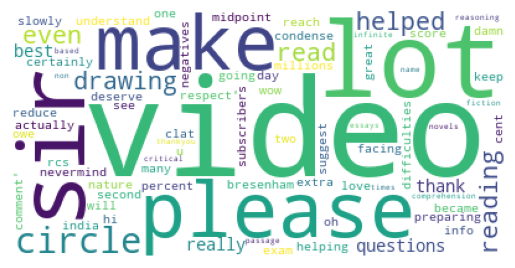

In [15]:
from wordcloud import WordCloud
text = df['comment'].values 

wordcloud = WordCloud(background_color='white',collocations=False).generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Converting Text into Features

Code performs feature extraction from text data using a bag-of-words approach with filtering based on word occurrence frequency and normalization using Min-Max scaling.


1. **Define Parameters:**
   - `N_occurance`: Threshold for the minimum number of occurrences required for a word to be included in the feature set.

2. **Extract Words from DataFrame:**
   - Extracts words from the DataFrame's 'comment' column and splits them into individual words.
   - Creates a bag of words (unique words) and initializes a dictionary `word_count` to store word frequencies.

3. **Count Word Occurrences:**
   - Iterates through each word in the bag of words and counts its occurrences in the text data.
   - Filters out words that occur fewer than `N_occurance` times, resulting in `filtered_words`.

4. **Create Evaluation Matrix:**
   - Initializes an evaluation matrix with zeros, where rows represent comments and columns represent filtered words.
   - Calculates the frequency of each filtered word in each comment and stores it in the evaluation matrix.

5. **Normalization:**
   - Uses Min-Max scaling to normalize the evaluation matrix, ensuring that values fall within the range [0, 1].
   - Normalized features are stored in the `features` variable.

In [17]:
import math 
from collections import Counter
import numpy as np

N_occurance = 5

# Use .loc to safely access the DataFrame
words = [df.loc[i, 'comment'].split() for i in df.index]
bag_of_words = sorted(list({word for list_ in words for word in list_}))
word_count = {word:0 for word in bag_of_words}
for word in bag_of_words:
    for list_ in words:
        if word in list_:
            word_count[word]+=1
filtered_words = [k for k,v in word_count.items() if v>N_occurance]
evaluation = np.zeros((len(df),len(filtered_words)))
for i in range(len(words)):
    counter = Counter(words[i])
    for k, v in counter.items():
        if k not in filtered_words:
            continue
        count = [1 for list_ in words if k in list_]
        evaluation[i][filtered_words.index(k)] = sum(count)/len(words)

# print(filtered_words)
print(evaluation.shape)

(9788, 2445)


In [18]:
features = evaluation
features

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [19]:
from sklearn import preprocessing
# features

min_max_scaler = preprocessing.MinMaxScaler()
features = min_max_scaler.fit_transform(evaluation)

In [20]:
type(evaluation)

numpy.ndarray

1. **RandomForestClassifier:**
   - Description: Random Forest is an ensemble learning method that constructs a multitude of decision trees during training and outputs the mode of the classes as the prediction.
   - Parameters:
     - `max_features='log2'`: The number of features to consider when looking for the best split. 'log2' indicates the base-2 logarithm of the number of features.
     - `n_estimators=1000`: The number of trees in the forest.
     - `criterion='entropy'`: The function to measure the quality of a split, where 'entropy' uses information gain.
     - `random_state=0`: Controls the randomness of the estimator.

2. **LinearSVC:**
   - Description: Linear Support Vector Classification is a linear classification model that finds the hyperplane that best separates the classes in the feature space.
   - Parameters:
     - `C=1.0`: Regularization parameter, which controls the trade-off between maximizing the margin and minimizing the classification error.
     - `random_state=0`: Controls the randomness of the estimator.

3. **MultinomialNB:**
   - Description: Multinomial Naive Bayes is a variant of the Naive Bayes algorithm suitable for classification with discrete features (e.g., word counts).
   - Parameters:
     - `alpha=1`: Additive smoothing parameter, which helps to handle zero probabilities in the data.
     - `fit_prior=True`: Whether to learn class prior probabilities from the data.

4. **LogisticRegression:**
   - Description: Logistic Regression is a linear model for binary classification that uses the logistic function to model the probability that a given instance belongs to a particular class.
   - Parameters:
     - `C=1.0`: Inverse of regularization strength, where smaller values specify stronger regularization.
     - `penalty='l2'`: Regularization term, where 'l2' refers to L2 regularization.
     - `solver='newton-cg'`: Algorithm to use in the optimization problem.

5. **DecisionTreeClassifier:**
   - Description: Decision Trees are a non-parametric supervised learning method used for classification and regression tasks, where the data is split based on feature values to maximize information gain.
   - Parameters:
     - `criterion='gini'`: The function to measure the quality of a split, where 'gini' uses Gini impurity.
     - `max_features=None`: The number of features to consider when looking for the best split, where None considers all features.
     - `min_samples_leaf=1`: The minimum number of samples required to be at a leaf node.
     - `min_samples_split=2`: The minimum number of samples required to split an internal node.
     - `random_state=0`: Controls the randomness of the estimator.

These explanations provide a brief overview of each model along with the key parameters specified in the brackets.

d:\MTECH\2-Semester\ML\ML_Project\paper-implement-repo\youtube-comments-categorization-master\venv\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
d:\MTECH\2-Semester\ML\ML_Project\paper-implement-repo\youtube-comments-categorization-master\venv\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
d:\MTECH\2-Semester\ML\ML_Project\paper-implement-repo\youtube-comments-categorization-master\venv\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
d:\MTECH\2-Semester\ML\ML_Project\paper-implement-repo\youtube-comments-categorization-master\venv\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWa

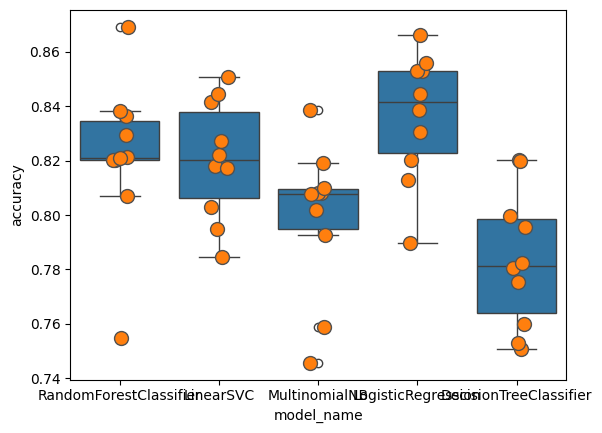

In [21]:
# Applying models

labels = df['category']
models = [
    RandomForestClassifier(max_features='log2', n_estimators=1000, criterion = 'entropy', 
                           random_state = 0),
    LinearSVC(C=1.0, random_state=0),
    MultinomialNB(alpha=1, fit_prior=True),
    LogisticRegression(C=1.0, penalty='l2', solver='newton-cg', random_state = 0),
    DecisionTreeClassifier(criterion='gini', 
                           max_features=None,min_samples_leaf=1, 
                           min_samples_split=2, random_state=0),
]

cv_df = pd.DataFrame()
entries = []

for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=10)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=10, jitter=True, linewidth=1)
plt.show()

### Comparison of Accuracies

In [22]:
# Printing the accuracies
cv_df.groupby('model_name').accuracy.mean()

model_name
DecisionTreeClassifier    0.783720
LinearSVC                 0.820395
LogisticRegression        0.836435
MultinomialNB             0.799043
RandomForestClassifier    0.821824
Name: accuracy, dtype: float64

In [23]:
features.shape

(9788, 2445)

### Applying Models and predicting the output with the actual output

In [34]:
X = features
y = df.iloc[:, 1].values
indices = range(len(X))

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices,
                                                                                 test_size=0.2, random_state=42)

In [67]:
# for scatter plot -> at the bottom

# Function to show the accuracy of each class
def acc_each_class(cf_matrix):
    total_comments = cf_matrix.sum(axis=1)
    correctly_classified = np.diagonal(cf_matrix)
    incorrectly_classified = total_comments-correctly_classified
    
    accuracy_each_class = correctly_classified/total_comments
    return accuracy_each_class
    # return total_comments, correctly_classified, incorrectly_classified


acc_corrective = []
acc_imperative = []
acc_interrogative = []
acc_miscellaneous = []
acc_negative = []
acc_positive = []

In [36]:
# Function to show original category vs predicted category

def show_prediction(y_pred, y_test):

    indices_match = y_pred == y_test

    df = pd.read_csv('Data/final_data.csv', header=None)

    get_comments = []

    for i in range(len(indices_test)):
        get_comments.append(df[0][indices_test[i]])


    data = list(zip(get_comments, y_test, y_pred))
    df_result = pd.DataFrame(data, columns=["comment", "original class", "predicted class"])
    return df_result

In [37]:
# Multinomial NB
from sklearn.naive_bayes import MultinomialNB

classifier = MultinomialNB(alpha=1, fit_prior=True)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_mnb = confusion_matrix(y_test, y_pred)


print("accuracy score: " + str(classifier.score(X_test, y_test)))

accuracy score: 0.8386108273748724


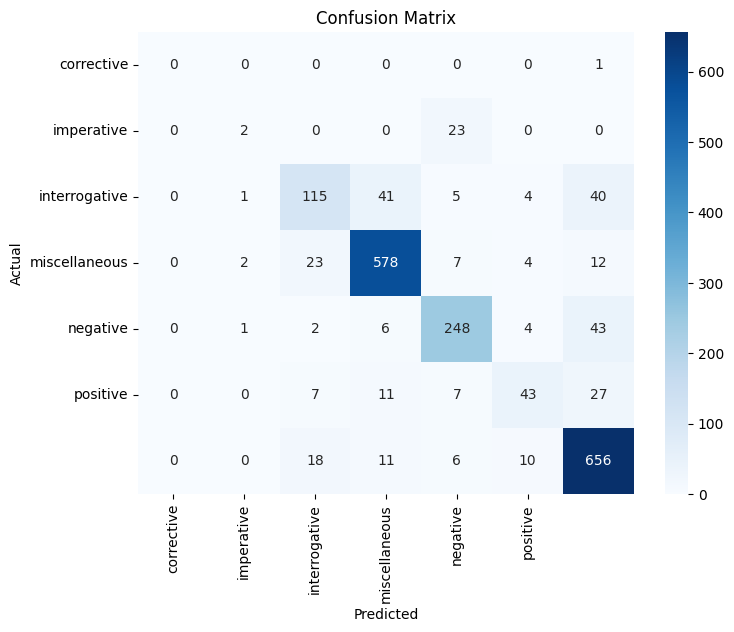

In [38]:
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_mnb, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [39]:
show_prediction(y_pred, y_test)

,comment,original class,predicted class
0,"Hey sir, I have alot of questions as I am conf...",positive,positive
1,Really helpful video..... if you guys can make...,positive,imperative
2,Extremely informative video. God bless you!,positive,positive
3,excellent work,positive,positive
4,Where are the Answer keys?,interrogative,interrogative
...,...,...,...
1953,Kerala❤️,positive,positive
1954,Please make a backend video,positive,positive
1955,Thank for this it's motivated myself ❤,interrogative,interrogative
1956,"1:59 acording to w3school, thats not a single ...",positive,positive


In [68]:
accuracies = acc_each_class(cm_mnb)

acc_corrective.append(accuracies[0])
acc_imperative.append(accuracies[1])
acc_interrogative.append(accuracies[2])
acc_miscellaneous.append(accuracies[3])
acc_negative.append(accuracies[4])
acc_positive.append(accuracies[5])

In [40]:
# Linear SVC
from sklearn.svm import SVC

classifier = SVC(C=1.0, gamma='scale', kernel='linear', random_state=0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_lsvc = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

accuracy score: 0.832482124616956


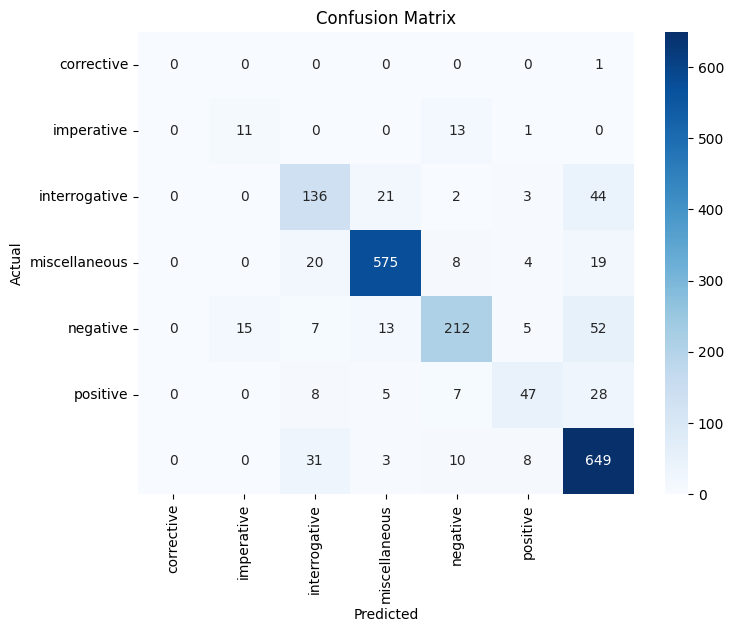

In [41]:
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lsvc, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [42]:
show_prediction(y_pred, y_test)

,comment,original class,predicted class
0,"Hey sir, I have alot of questions as I am conf...",positive,positive
1,Really helpful video..... if you guys can make...,positive,positive
2,Extremely informative video. God bless you!,positive,positive
3,excellent work,positive,positive
4,Where are the Answer keys?,interrogative,interrogative
...,...,...,...
1953,Kerala❤️,positive,positive
1954,Please make a backend video,positive,positive
1955,Thank for this it's motivated myself ❤,interrogative,interrogative
1956,"1:59 acording to w3school, thats not a single ...",positive,positive


In [69]:
accuracies = acc_each_class(cm_lsvc)

acc_corrective.append(accuracies[0])
acc_imperative.append(accuracies[1])
acc_interrogative.append(accuracies[2])
acc_miscellaneous.append(accuracies[3])
acc_negative.append(accuracies[4])
acc_positive.append(accuracies[5])

In [43]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(C=1.0, penalty='l2', solver='newton-cg', random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_lr = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

accuracy score: 0.8488253319713994


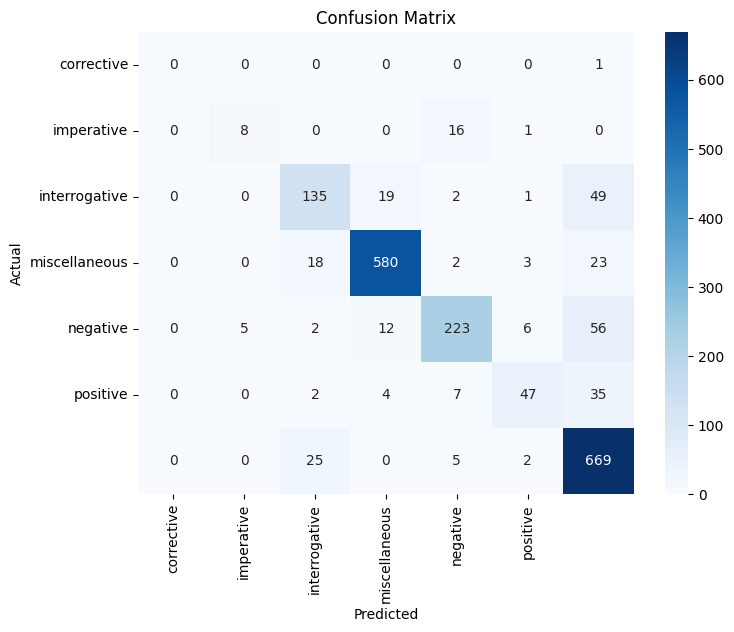

In [44]:
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [45]:
show_prediction(y_pred, y_test)

,comment,original class,predicted class
0,"Hey sir, I have alot of questions as I am conf...",positive,positive
1,Really helpful video..... if you guys can make...,positive,positive
2,Extremely informative video. God bless you!,positive,positive
3,excellent work,positive,positive
4,Where are the Answer keys?,interrogative,interrogative
...,...,...,...
1953,Kerala❤️,positive,positive
1954,Please make a backend video,positive,positive
1955,Thank for this it's motivated myself ❤,interrogative,interrogative
1956,"1:59 acording to w3school, thats not a single ...",positive,positive


In [70]:
accuracies = acc_each_class(cm_lr)

acc_corrective.append(accuracies[0])
acc_imperative.append(accuracies[1])
acc_interrogative.append(accuracies[2])
acc_miscellaneous.append(accuracies[3])
acc_negative.append(accuracies[4])
acc_positive.append(accuracies[5])

In [50]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(max_features='log2', n_estimators=1000, criterion = 'entropy', random_state = 0)

classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_rf = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

accuracy score: 0.832482124616956


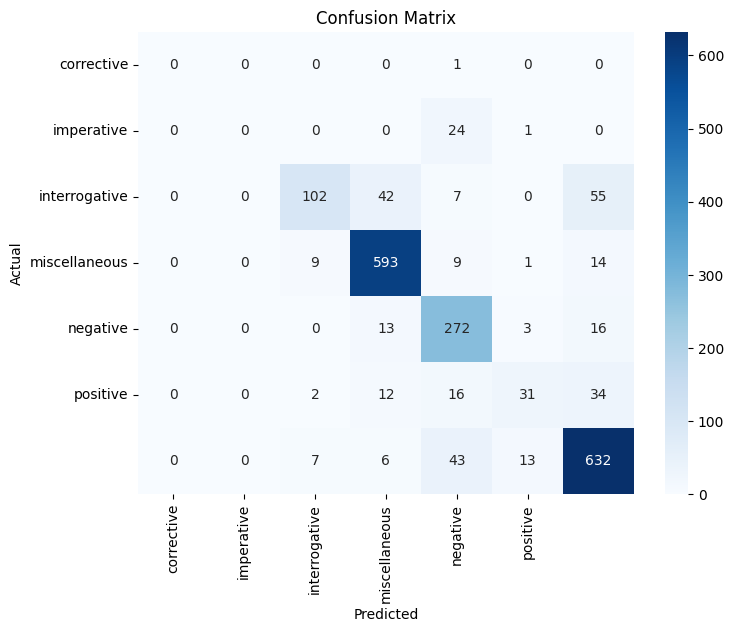

In [51]:
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [52]:
show_prediction(y_pred, y_test)

,comment,original class,predicted class
0,"Hey sir, I have alot of questions as I am conf...",positive,positive
1,Really helpful video..... if you guys can make...,positive,miscellaneous
2,Extremely informative video. God bless you!,positive,positive
3,excellent work,positive,positive
4,Where are the Answer keys?,interrogative,interrogative
...,...,...,...
1953,Kerala❤️,positive,positive
1954,Please make a backend video,positive,positive
1955,Thank for this it's motivated myself ❤,interrogative,interrogative
1956,"1:59 acording to w3school, thats not a single ...",positive,positive


In [71]:
accuracies = acc_each_class(cm_rf)

acc_corrective.append(accuracies[0])
acc_imperative.append(accuracies[1])
acc_interrogative.append(accuracies[2])
acc_miscellaneous.append(accuracies[3])
acc_negative.append(accuracies[4])
acc_positive.append(accuracies[5])

In [ ]:
# Show falsely predicted comments

def show_neg_prediction(y_pred, y_test):

    indices_match = y_pred == y_test

    df = pd.read_csv('Data/final_data.csv', header=None)

    get_comments = []

    for i in range(len(indices_test)):
        if indices_match[i] == False:
            get_comments.append(df['comment'][indices_test[i]])


    data = list(zip(get_comments, y_test, y_pred))
    df_result = pd.DataFrame(data, columns = ["comment", "original class", "predicted class"])
    return df_result

In [ ]:
df_ = show_prediction(y_pred, y_test)
pd.options.display.max_colwidth = 150
df_.iloc[200:250]


In [53]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier(criterion='gini', 
                                    max_features=None,min_samples_leaf=1, 
                                    min_samples_split=2, random_state=0)

classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_dt = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

accuracy score: 0.789070480081716


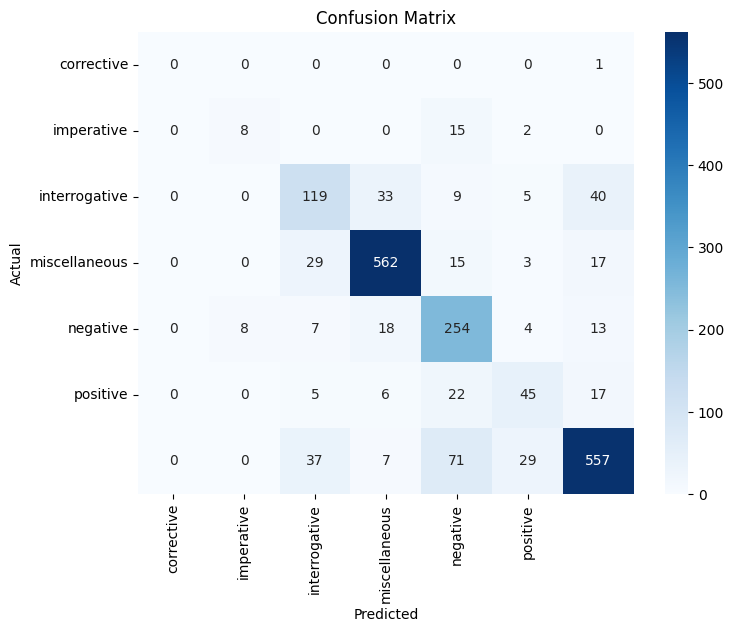

In [54]:
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [55]:
show_prediction(y_pred, y_test)

,comment,original class,predicted class
0,"Hey sir, I have alot of questions as I am conf...",positive,positive
1,Really helpful video..... if you guys can make...,positive,miscellaneous
2,Extremely informative video. God bless you!,positive,positive
3,excellent work,positive,miscellaneous
4,Where are the Answer keys?,interrogative,interrogative
...,...,...,...
1953,Kerala❤️,positive,positive
1954,Please make a backend video,positive,positive
1955,Thank for this it's motivated myself ❤,interrogative,interrogative
1956,"1:59 acording to w3school, thats not a single ...",positive,positive


In [72]:
accuracies = acc_each_class(cm_dt)

acc_corrective.append(accuracies[0])
acc_imperative.append(accuracies[1])
acc_interrogative.append(accuracies[2])
acc_miscellaneous.append(accuracies[3])
acc_negative.append(accuracies[4])
acc_positive.append(accuracies[5])

In [ ]:
from sklearn import tree
tree.export_graphviz(classifier, out_file='tree.dot') 
tree.plot_tree(classifier)

## Histogram

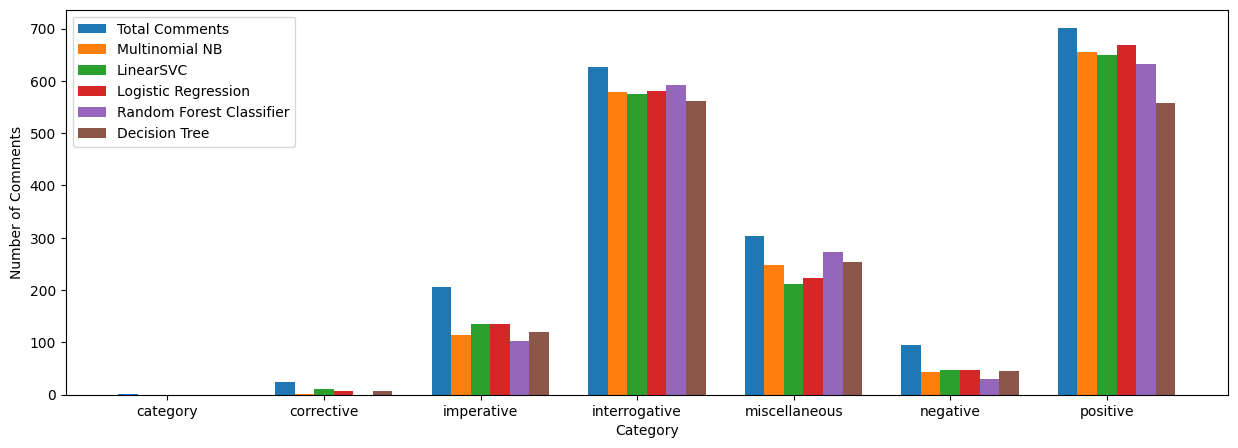

In [64]:
import numpy as np
import matplotlib.pyplot as plt

def acc_each_category(cf_matrix):
    total_comments = cf_matrix.sum(axis=1)
    correctly_classified = np.diagonal(cf_matrix)
    return correctly_classified

y = cm_dt.sum(axis=1)

z1 = acc_each_category(cm_mnb)
z2 = acc_each_category(cm_lsvc)
z3 = acc_each_category(cm_lr)
z4 = acc_each_category(cm_rf)
z5 = acc_each_category(cm_dt)

# Define x_tick with unique labels
x_tick = np.unique(y_test)

# Define the width of each bar
w = 0.125

# Define x positions for each group of bars
x = np.arange(len(x_tick))
x1 = x - 2*w
x2 = x - w
x3 = x
x4 = x + w
x5 = x + 2*w

# Plot the bar chart
plt.bar(x1, y, w, label="Total Comments")
plt.bar(x2, z1, w, label="Multinomial NB")
plt.bar(x3, z2, w, label="LinearSVC")
plt.bar(x4, z3, w, label="Logistic Regression")
plt.bar(x5, z4, w, label="Random Forest Classifier")
plt.bar(x + 3*w, z5, w, label="Decision Tree")  # Adjusting x for the last set of bars

# Set x-axis tick labels
plt.xticks(ticks=x, labels=x_tick)

# Set plot labels and legend
plt.xlabel("Category")
plt.ylabel("Number of Comments")
plt.legend()

# Show plot
plt.rcParams["figure.figsize"] = (25,5)
plt.show()


## Percentage of accuracy in each class

In [73]:
corr = [i * 100 for i in acc_corrective]
imp = [i * 100 for i in acc_imperative]
inte = [i * 100 for i in acc_interrogative]
mis = [i * 100 for i in acc_miscellaneous]
neg = [i * 100 for i in acc_negative]
pos = [i * 100 for i in acc_positive]

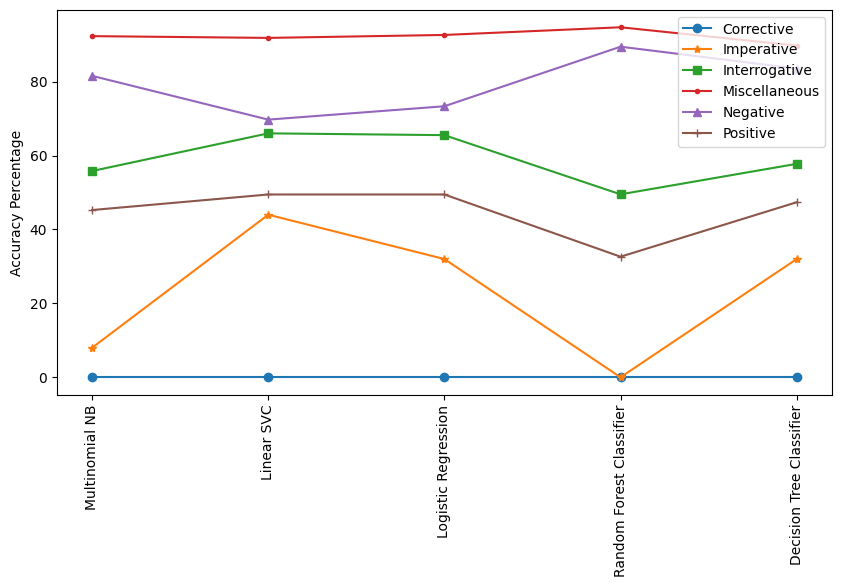

In [77]:
import matplotlib.pyplot as plt

# x1 = [10,20,30,40,50]
x1 = ['Multinomial NB','Linear SVC','Logistic Regression','Random Forest Classifier','Decision Tree Classifier']
# corrective
y1 = corr
# plotting the line 1 points 
plt.plot(x1, y1, label = "Corrective", marker='o')

# imperative
y2 = imp
# plotting the line 2 points 
plt.plot(x1, y2, label = "Imperative", marker='*')

# interrogative
y3 = inte
# plotting the line 2 points 
plt.plot(x1, y3, label = "Interrogative", marker='s')

# Miscellaneous
y4 = mis
# plotting the line 2 points 
plt.plot(x1, y4, label = "Miscellaneous", marker='.')

# Negative
y5 = neg
# plotting the line 2 points 
plt.plot(x1, y5, label = "Negative", marker='^')

# Positive
y6 = pos
# plotting the line 2 points 
plt.plot(x1, y6, label = "Positive", marker='+')


plt.xlabel('')
# Set the y axis label of the current axis.
plt.ylabel('Accuracy Percentage')
# Set a title of the current axes.
plt.title('')
# show a legend on the plot
plt.legend()

plt.xticks(rotation=90)
# Display a figure.
plt.rcParams["figure.figsize"] = (9,5)
plt.show()

## Plotting accuracy vs data size

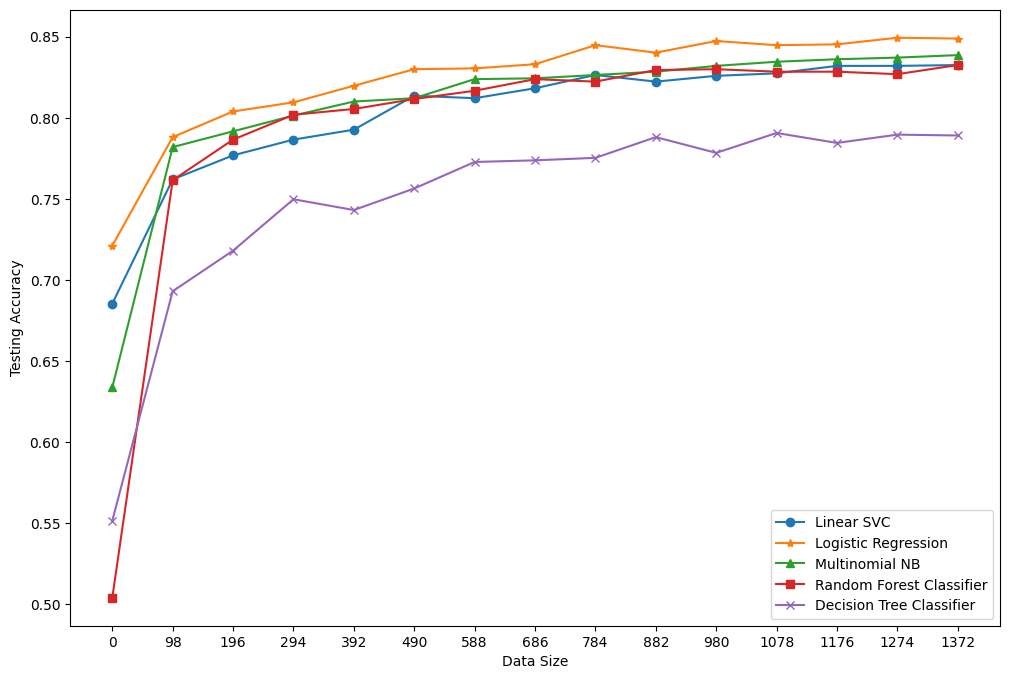

In [78]:
def plot_acc_curve(classifier, linestyle, label):    
    
    num_of_splits = 14
    each_split_size = len(X_train)//num_of_splits

    each_split = 98
    scores = []

    for i in range(num_of_splits+1):
        split_X_train = X_train[0:each_split]
        split_y_train = y_train[0:each_split]

        each_split += each_split_size

        classifier.fit(split_X_train, split_y_train)
        scores.append(classifier.score(X_test, y_test))
    
    m = 14
    n = 98
    x_splits = list(range(0, (m+1)*n, n))

    plt.xlabel('Data Size')
    plt.ylabel('Testing Accuracy')
    plt.plot(x_splits, scores, linestyle, label = label)
    plt.xticks(x_splits)
    plt.legend(loc="best")
    
    return plt
    

plt.figure(figsize=(12,8))

# Linear SVC
classifier = SVC(C=1.0, gamma='scale', kernel='linear', random_state=0)
plot_acc_curve(classifier, linestyle = 'o-', label="Linear SVC")

# Logistic Regression
classifier = LogisticRegression(C=1.0, penalty='l2', solver='newton-cg', random_state = 0)
plot_acc_curve(classifier, linestyle = '*-', label="Logistic Regression")

# Multinomial NB
classifier = MultinomialNB(alpha=1, fit_prior=True)
plot_acc_curve(classifier, linestyle = '^-', label="Multinomial NB")

# Random Forest Classifier
classifier = RandomForestClassifier(max_features='log2', n_estimators=1000, criterion = 'entropy', random_state = 0)
plot_acc_curve(classifier, linestyle = 's-', label="Random Forest Classifier")

# Decision Tree Classifier
classifier = DecisionTreeClassifier(criterion='gini', 
                                    max_features=None, min_samples_leaf=1, 
                                    min_samples_split=2, random_state=0)
plot_acc_curve(classifier, linestyle = 'x-', label="Decision Tree Classifier")

plt.show()

## PLotting the learning curves

## Implementing the Neural Network

Here also we are doing the preprocessing part. But as we have done it initially so we are not implementing it here.

### Using LSTM

Using LSTM (Long Short-Term Memory) for predicting the type of category for comments as LSTM is well-suited for processing sequential data like text. Comments often have dependencies on previous words or phrases to understand the context and sentiment correctly. LSTM, being a type of recurrent neural network (RNN), can capture these dependencies effectively due to its ability to retain information over time.

1. **Tokenizer Configuration**:
   - The `Tokenizer` class from Keras is used to tokenize the text data.
   - `MAX_NB_WORDS` specifies the maximum number of words to be used, while `MAX_SEQUENCE_LENGTH` specifies the maximum length of each comment.
   - `EMBEDDING_DIM` determines the dimensionality of the word embeddings.
   - `filters` parameter in `Tokenizer` is used to specify characters to filter out from the text data during tokenization.
   - `fit_on_texts()` method is used to fit the tokenizer on the comment data.

2. **Tokenization and Padding**:
   - The comments are converted to sequences of integers using `texts_to_sequences()` method of the tokenizer.
   - `pad_sequences()` is used to ensure that all sequences have the same length by padding or truncating as necessary.

3. **One-Hot Encoding Labels**:
   - `pd.get_dummies()` is used to one-hot encode the categorical labels (`category`) of the comments.

4. **Train-Test Split**:
   - The dataset is split into training and testing sets using `train_test_split()` from `sklearn.model_selection`.

5. **Model Definition**:
   - A sequential model is defined using `Sequential()` from Keras.
   - `Embedding` layer converts input sequences of integers into dense vectors of fixed size.
   - `SpatialDropout1D` layer randomly sets a fraction of input units to zero to prevent overfitting.
   - `LSTM` layer with 128 units is added, followed by a dropout layer.
   - The output layer consists of a `Dense` layer with softmax activation to output probabilities for each category.
   - The model is compiled with categorical cross-entropy loss and Adam optimizer.

6. **Model Training**:
   - The model is trained using `fit()` method with specified number of epochs and batch size.
   - `EarlyStopping` callback is used to stop training if the validation loss doesn't improve after a certain number of epochs.

7. **Model Evaluation**:
   - The model is evaluated on the test set using `evaluate()` method.
   - The loss and accuracy metrics are printed.

8. **Training History Visualization**:
   - Training and validation loss are plotted against epochs to visualize model performance over training.
   - Training and validation accuracy are also plotted for performance comparison.

In [80]:

from keras.preprocessing.text import Tokenizer

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['comment'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

ModuleNotFoundError: No module named 'tensorflow.python'

In [ ]:
from keras.preprocessing.sequence import pad_sequences

X = tokenizer.texts_to_sequences(df['comment'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

In [81]:
Y = pd.get_dummies(df['category']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (9788, 7)


In [82]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(8809, 2445) (8809, 7)
(979, 2445) (979, 7)


In [83]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


ModuleNotFoundError: No module named 'tensorflow.python'

In [84]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

AttributeError: 'SVC' object has no attribute 'evaluate'

In [ ]:
import matplotlib.pyplot as plt

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
